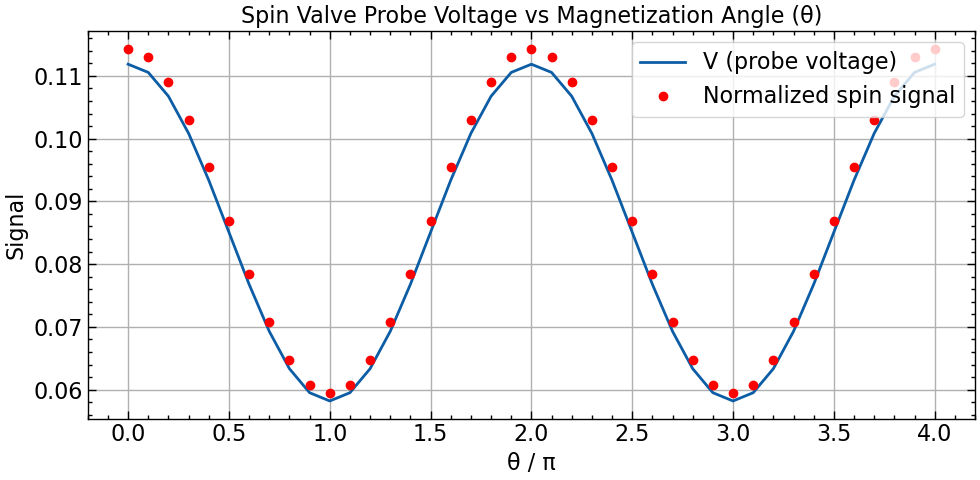

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

# === Physical Constants and Parameters ===
hbar = 1.06e-34         # Planck's constant [J·s]
q = 1.6e-19             # Elementary charge [C]
m = 0.1 * 9.1e-31       # Effective mass [kg]
a = 2.5e-9              # Lattice constant [m]
t0 = hbar**2 / (2 * m * a**2 * q)  # Hopping energy [eV]

# === Pauli Matrices (spin space) ===
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
I2 = np.eye(2)  # 2×2 identity for spin
zplus = 1j * 1e-12  # Infinitesimal for Green's function

# === Lattice Parameters ===
Np = 50          # Number of lattice sites
N1, N2 = 10, 20  # Positions of voltage probes
EE = t0          # Energy at which to evaluate Green's function

# === Projector Matrices (site-resolved coupling) ===
L = np.zeros((Np, Np)); L[0, 0] = 1         # Left terminal at site 1
R = np.zeros((Np, Np)); R[-1, -1] = 1       # Right terminal at site Np
L1 = np.zeros((Np, Np)); L1[N1-1, N1-1] = 0.1  # Probe 1 (weakly coupled)
L2 = np.zeros((Np, Np)); L2[N2-1, N2-1] = 0.1  # Probe 2 (weakly coupled)

# === Kronecker Helper ===
def kron_proj(mat2x2, site_proj):
    return np.kron(site_proj, mat2x2)

# === Data Arrays ===
angles = np.linspace(0, 4*np.pi, 41)
VV2, VVR, XX2 = [], [], []

# === Build Tight-Binding Hamiltonian ===
H0 = np.eye(Np)
HL = np.diag(np.ones(Np - 1), -1)
HR = np.diag(np.ones(Np - 1), 1)

H_spin = (2 * t0) * np.kron(H0, I2) - t0 * np.kron(HL, I2) - t0 * np.kron(HR, I2)

# === Sweep Over θ ===
for theta in angles:
    # Magnetization vectors
    P1 = np.array([0, 0, 0.7])                        # Fixed along ẑ
    P2 = np.array([np.sin(theta), 0, np.cos(theta)])  # Rotated in xz-plane

    # Self-energies from leads
    ck = 1 - (EE + zplus) / (2 * t0)
    ka = np.arccos(ck)
    eika = np.exp(1j * ka)

    sL = -t0 * eika * I2
    sR = sL.copy()
    s1 = -t0 * eika * (I2 + P1[0]*sx + P1[1]*sy + P1[2]*sz)
    s2 = -t0 * eika * (I2 + P2[0]*sx + P2[1]*sy + P2[2]*sz)

    # Embed in full system size (with Kronecker)
    sigL = kron_proj(sL, L)
    sigR = kron_proj(sR, R)
    sig1 = kron_proj(s1, L1)
    sig2 = kron_proj(s2, L2)

    # Broadening matrices Γ = i(Σ - Σ†)
    gamL = 1j * (sigL - sigL.conj().T)
    gamR = 1j * (sigR - sigR.conj().T)
    gam1 = 1j * (sig1 - sig1.conj().T)
    gam2 = 1j * (sig2 - sig2.conj().T)

    # Green's function G(E)
    G = np.linalg.inv((EE + zplus) * np.eye(2*Np) - H_spin - sigL - sigR - sig1 - sig2)

    # === Transmission Between Terminals ===
    TM1L = np.real(np.trace(gam1 @ G @ gamL @ G.conj().T))
    TML1 = np.real(np.trace(gamL @ G @ gam1 @ G.conj().T))
    Taa = np.array([[0, TM1L], [TML1, 0]])

    TM12 = np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T))
    TM1R = np.real(np.trace(gam1 @ G @ gamR @ G.conj().T))
    TML2 = np.real(np.trace(gamL @ G @ gam2 @ G.conj().T))
    TMLR = np.real(np.trace(gamL @ G @ gamR @ G.conj().T))
    Tab = np.array([[TM12, TM1R], [TML2, TMLR]])

    TM21 = np.real(np.trace(gam2 @ G @ gam1 @ G.conj().T))
    TM2L = np.real(np.trace(gam2 @ G @ gamL @ G.conj().T))
    TMR1 = np.real(np.trace(gamR @ G @ gam1 @ G.conj().T))
    TMRL = np.real(np.trace(gamR @ G @ gamL @ G.conj().T))
    Tba = np.array([[TM21, TM2L], [TMR1, TMRL]])

    TM2R = np.real(np.trace(gam2 @ G @ gamR @ G.conj().T))
    TMR2 = np.real(np.trace(gamR @ G @ gam2 @ G.conj().T))
    Tbb = np.array([[0, TM2R], [TMR2, 0]])

    # === Landauer-Büttiker Voltage Solver ===
    Taa = np.diag(np.sum(Taa, axis=1) + np.sum(Tba, axis=1)) - Taa
    Tba = -Tba
    Tbb = np.diag(np.sum(Tab, axis=1) + np.sum(Tbb, axis=1)) - Tbb
    Tab = -Tab

    V = -np.linalg.inv(Tbb) @ Tba @ np.array([1, 0])
    VV2.append(np.real(V[0]))  # Voltage at probe
    VVR.append(np.real(V[1]))

    # === Normalized Spin Signal ===
    Gam_n = G @ (gam1 + V[0]*gam2 + V[1]*gamR) @ G.conj().T
    idx = 2*(N2 - 1)
    Gn = Gam_n[idx:idx+2, idx:idx+2]
    A = 1j * (G - G.conj().T)[idx:idx+2, idx:idx+2]
    g2 = 1j * (s2 - s2.conj().T)
    XX2.append(np.real(np.trace(g2 @ Gn) / np.trace(g2 @ A)))


# === Plot Results ===
theta_pi = angles / np.pi
plt.figure(figsize=(10, 5))
plt.plot(theta_pi, VV2, label="V (probe voltage)", linewidth=2)
plt.plot(theta_pi, XX2, 'ro', label="Normalized spin signal", linewidth=2)
plt.xlabel("θ / π")
plt.ylabel("Signal")
plt.title("Spin Valve Probe Voltage vs Magnetization Angle (θ)")
plt.grid(True)
plt.legend(loc="upper right", bbox_to_anchor=(1, 1), frameon=True)
plt.tight_layout()
plt.show()



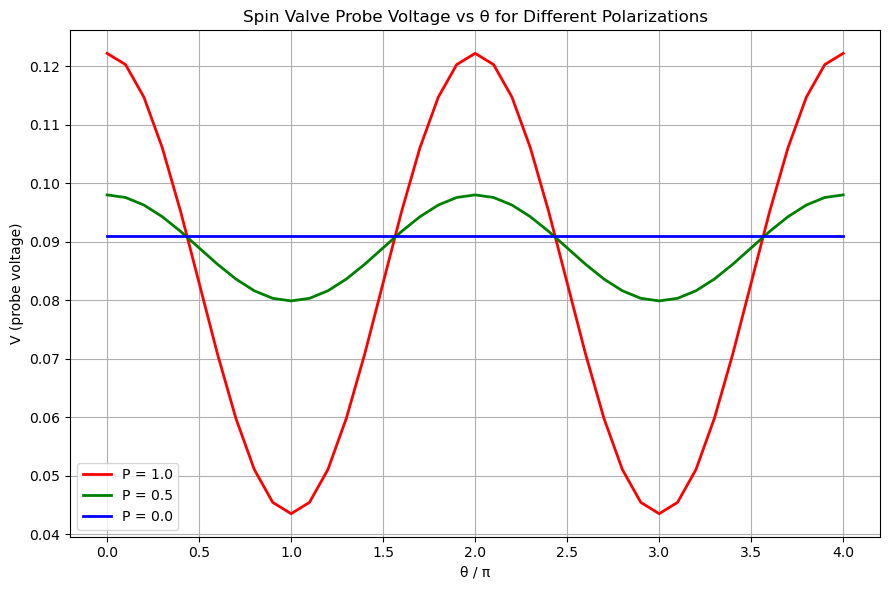

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# === Physical Constants and Parameters ===
hbar = 1.06e-34         # Planck's constant [J·s]
q = 1.6e-19             # Elementary charge [C]
m = 0.1 * 9.1e-31       # Effective mass [kg]
a = 2.5e-9              # Lattice constant [m]
t0 = hbar**2 / (2 * m * a**2 * q)  # Hopping energy [eV]

# === Pauli Matrices (spin space) ===
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
I2 = np.eye(2)
zplus = 1j * 1e-12

# === Lattice Parameters ===
Np = 50
N1, N2 = 10, 20
EE = t0

# === Projector Matrices (site-resolved coupling) ===
L = np.zeros((Np, Np)); L[0, 0] = 1
R = np.zeros((Np, Np)); R[-1, -1] = 1
L1 = np.zeros((Np, Np)); L1[N1-1, N1-1] = 0.1
L2 = np.zeros((Np, Np)); L2[N2-1, N2-1] = 0.1

def kron_proj(mat2x2, site_proj):
    return np.kron(site_proj, mat2x2)

angles = np.linspace(0, 4*np.pi, 41)
theta_pi = angles / np.pi

# === Different Polarization Levels ===
polarizations = [1.0, 0.5, 0.0]
colors = ['r', 'g', 'b']
voltages_by_p = []

for P in polarizations:
    VV2 = []

    H0 = np.eye(Np)
    HL = np.diag(np.ones(Np - 1), -1)
    HR = np.diag(np.ones(Np - 1), 1)
    H_spin = (2 * t0) * np.kron(H0, I2) - t0 * np.kron(HL, I2) - t0 * np.kron(HR, I2)

    for theta in angles:
        P1 = np.array([0, 0, P])
        P2 = P * np.array([np.sin(theta), 0, np.cos(theta)])

        ck = 1 - (EE + zplus) / (2 * t0)
        ka = np.arccos(ck)
        eika = np.exp(1j * ka)

        sL = -t0 * eika * I2
        sR = sL.copy()
        s1 = -t0 * eika * (I2 + P1[0]*sx + P1[1]*sy + P1[2]*sz)
        s2 = -t0 * eika * (I2 + P2[0]*sx + P2[1]*sy + P2[2]*sz)

        sigL = kron_proj(sL, L)
        sigR = kron_proj(sR, R)
        sig1 = kron_proj(s1, L1)
        sig2 = kron_proj(s2, L2)

        gamL = 1j * (sigL - sigL.conj().T)
        gamR = 1j * (sigR - sigR.conj().T)
        gam1 = 1j * (sig1 - sig1.conj().T)
        gam2 = 1j * (sig2 - sig2.conj().T)

        G = np.linalg.inv((EE + zplus) * np.eye(2*Np) - H_spin - sigL - sigR - sig1 - sig2)

        TM1L = np.real(np.trace(gam1 @ G @ gamL @ G.conj().T))
        TML1 = np.real(np.trace(gamL @ G @ gam1 @ G.conj().T))
        Taa = np.array([[0, TM1L], [TML1, 0]])

        TM12 = np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T))
        TM1R = np.real(np.trace(gam1 @ G @ gamR @ G.conj().T))
        TML2 = np.real(np.trace(gamL @ G @ gam2 @ G.conj().T))
        TMLR = np.real(np.trace(gamL @ G @ gamR @ G.conj().T))
        Tab = np.array([[TM12, TM1R], [TML2, TMLR]])

        TM21 = np.real(np.trace(gam2 @ G @ gam1 @ G.conj().T))
        TM2L = np.real(np.trace(gam2 @ G @ gamL @ G.conj().T))
        TMR1 = np.real(np.trace(gamR @ G @ gam1 @ G.conj().T))
        TMRL = np.real(np.trace(gamR @ G @ gamL @ G.conj().T))
        Tba = np.array([[TM21, TM2L], [TMR1, TMRL]])

        TM2R = np.real(np.trace(gam2 @ G @ gamR @ G.conj().T))
        TMR2 = np.real(np.trace(gamR @ G @ gam2 @ G.conj().T))
        Tbb = np.array([[0, TM2R], [TMR2, 0]])

        Taa = np.diag(np.sum(Taa, axis=1) + np.sum(Tba, axis=1)) - Taa
        Tba = -Tba
        Tbb = np.diag(np.sum(Tab, axis=1) + np.sum(Tbb, axis=1)) - Tbb
        Tab = -Tab

        V = -np.linalg.inv(Tbb) @ Tba @ np.array([1, 0])
        VV2.append(np.real(V[0]))

    voltages_by_p.append(VV2)

# === Plotting ===
plt.figure(figsize=(9, 6))
for VV2, P, color in zip(voltages_by_p, polarizations, colors):
    plt.plot(theta_pi, VV2, label=f'P = {P}', linewidth=2, color=color)

plt.xlabel("θ / π")
plt.ylabel("V (probe voltage)")
plt.title("Spin Valve Probe Voltage vs θ for Different Polarizations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

